<a href="https://colab.research.google.com/github/chang-heekim/MNIST_CNN/blob/main/Pytorch_CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
plt.style.use('seaborn')

import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision import transforms
from torchsummary import summary

# Load Dataset

In [2]:
data_root = os.path.join(os.getcwd(), 'data')

transform = transforms.Compose([
    transforms.ToTensor()
])

train_datasets = MNIST(root=data_root, download=True, train=True, transform=transform)
val_datasets = MNIST(root=data_root, download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=100, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_datasets, batch_size=100, shuffle=False, num_workers=2)

In [3]:
for sample_batch in train_loader:
    print(sample_batch)
    print(sample_batch[0].shape)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

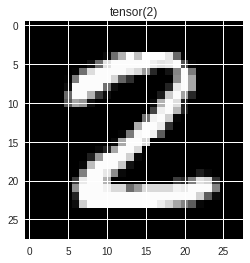

In [4]:
sample = next(iter(train_loader))
image, label = sample[0][0], sample[1][0]

plt.imshow(image.reshape(28, 28), 'gray')
plt.title(label)
plt.show()

# Define CNN

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),     # B x 32 x 28 x 28             
            nn.ReLU(),
            nn.MaxPool2d(2, 2)             # B x 32 x 14 x 14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),    # B x 64 x 14 x 14 
            nn.ReLU(),
            nn.MaxPool2d(2, 2)             # B x 64 x 7 x 7
        )
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        out = self.fc2(x)
        return out

# Define hyperparameters

In [6]:
lr = 1e-3
epochs = 15
log_interval = 100

# Define model & optimizer & loss function

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = CNN().to(device)
summary(model, input_size=(1, 28, 28))

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
            Linear-8                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 1.61
Estimated Total Size (MB): 2.26
----------------------------------------------------------------


# Training & Validation

In [9]:
train_result = []
val_result = []

for epoch in range(1, epochs + 1):
    # train mode
    model.train()

    for batch_idx, (images, labels) in enumerate(train_loader):
        current_loss = 0
        current_correct = 0
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        loss = loss_function(outputs, labels)

        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_loss += loss.item() 
        current_correct += torch.sum(preds == labels.data)

        if batch_idx % log_interval == 0:
            train_loss = current_loss / log_interval
            train_acc = current_correct / log_interval

            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}, Train Acc: {:.2f}".format(
                epoch, 
                batch_idx * len(images), 
                len(train_loader) * 100, 
                100 * batch_idx / len(train_loader), 
                train_loss, 
                train_acc))
            
    train_result.append((current_loss / len(images), current_correct / len(images)))

    # val mode
    with torch.no_grad():
        model.eval()
        val_loss = 0
        val_correct = 0
        for idx, (val_images, val_labels) in enumerate(val_loader):

            val_images, val_labels = val_images.to(device), val_labels.to(device)

            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)

            val_loss += loss_function(val_outputs, val_labels) / val_outputs.shape[0]
            val_correct += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0]

    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_acc = val_correct / len(val_loader)

    val_result.append((val_epoch_loss, val_epoch_acc))
    print("Validation set: Val Loss: {:.6f}, Val Acc: {:.2f}".format(val_epoch_loss, val_epoch_acc))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 0.023073, Train Acc: 0.10
Train Epoch: 1 [10000/60000 (17%)]	Train Loss: 0.022940, Train Acc: 0.12
Train Epoch: 1 [20000/60000 (33%)]	Train Loss: 0.023031, Train Acc: 0.04
Train Epoch: 1 [30000/60000 (50%)]	Train Loss: 0.022876, Train Acc: 0.15
Train Epoch: 1 [40000/60000 (67%)]	Train Loss: 0.022902, Train Acc: 0.08
Train Epoch: 1 [50000/60000 (83%)]	Train Loss: 0.022831, Train Acc: 0.14
Validation set: Val Loss: 0.022732, Val Acc: 0.12
Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.022630, Train Acc: 0.19
Train Epoch: 2 [10000/60000 (17%)]	Train Loss: 0.022679, Train Acc: 0.20
Train Epoch: 2 [20000/60000 (33%)]	Train Loss: 0.022628, Train Acc: 0.19
Train Epoch: 2 [30000/60000 (50%)]	Train Loss: 0.022565, Train Acc: 0.24
Train Epoch: 2 [40000/60000 (67%)]	Train Loss: 0.022464, Train Acc: 0.29
Train Epoch: 2 [50000/60000 (83%)]	Train Loss: 0.022474, Train Acc: 0.31
Validation set: Val Loss: 0.022252, Val Acc: 0.43
Train Epoch: 3 [0/60000 (0%)]	Trai

# Visualization Loss & Accuracy

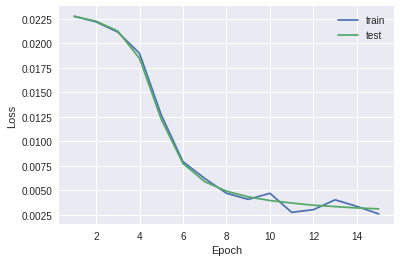

In [10]:
plt.plot([i for i in range(1, epochs + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(1, epochs + 1)], [i[0] for i in val_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

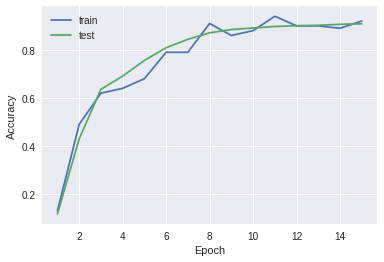

In [11]:
plt.plot([i for i in range(1, epochs + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(1, epochs + 1)], [i[1] for i in val_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()